In [2]:
import json

import pandas as pd
import wandb


def get_tables(run_id):
    with wandb.init() as run:
        dfs = {}
        for bench in ["bioasq"]:  # ['medqa', 'mmlumed', 'medmcqa', 'bioasq']:
            artifact = run.use_artifact(
                f"liac/OntoRAG-biomed/run-{run_id}-results_{bench}:v0",
                type="run_table",
            )
            artifact_dir = artifact.download()
            dfjson = json.load(
                open(artifact_dir + f"/results_{bench}.table.json")
            )
            df = pd.DataFrame(dfjson["data"], columns=dfjson["columns"])
            dfs[bench] = df
    return dfs


# match the keys with the names
runs = {
    "63jneekd": "orag-hyq-tm",
    "3njkj2tw": "orag-tm",
    "bj77mnsq": "orag-hyq",
    "nt9v14x0": "orag-simple",
    "chgt9pvp": "cot",
    "f3rej8wv": "zeroshot",
}

for run, name in runs.items():
    dfm = get_tables(run)
    for k, df in dfm.items():
        df.to_csv(f"data/_{k}_{name}.csv", index=False, sep="\t")

wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  


## Accuracy for ontorags, when context was retrieved

In [5]:
def clean_model_answer_abcde(model_out):
    """Process the model output to get the answer."""
    try:
        model_out = model_out.split("Answer:")[1].strip()
    except:
        return None
    inter = set(model_out).intersection(set("ABCDE"))
    if len(model_out) == 1:
        if model_out in list("ABCDE"):
            return model_out
    elif inter:
        if len(inter) == 1:
            return inter.pop()
        elif ":" in model_out:
            if model_out.split(":")[0] in "ABCDE":
                return model_out.split(":")[0]
    return None


def accuracy_yn(df, s):
    # preprocess choice_answer
    df["choice_answer_proc"] = (
        df["choice_answer"]
        .astype(str)
        .str.split("Answer:")
        .apply(lambda x: x[1] if len(x) > 1 else x[0])
    )
    acc = (
        df["choice_answer_proc"].str.strip().str.lower()
        == df["answer"].str.strip().str.lower()
    ).mean()
    print(f"{s} {acc*100:.4f}%")


def accuracy_abcde(df, s):
    # preprocess choice_answer
    df["choice_answer_proc"] = df["choice_answer"].apply(
        clean_model_answer_abcde
    )
    acc = (df["choice_answer_proc"] == df["answer"]).mean()
    print(f"{s} {acc*100:.4f}%")


bench = "bioasq"
accuracy_metric = accuracy_yn
zs = pd.read_csv(f"data/_{bench}_zeroshot.csv", sep="\t")
cot = pd.read_csv(f"data/_{bench}_cot.csv", sep="\t")
for name in runs.values():
    df = pd.read_csv(f"data/_{bench}_{name}.csv", sep="\t")
    print(f"\n{name}:")
    accuracy_metric(df, s="Accuracy: ")
    if "orag" in name:
        accuracy_metric(
            df[df.context.astype(str).str.len() > 2],
            s="Accuracy (if context): ",
        )
        accuracy_metric(
            zs[df.context.astype(str).str.len() > 2],
            s="Zeroshot acc on these: ",
        )
        accuracy_metric(
            cot[df.context.astype(str).str.len() > 2],
            s="CoT acc on these:      ",
        )


orag-hyq-tm:
Accuracy:  65.0446%
Accuracy (if context):  71.9588%
Zeroshot acc on these:  87.4227%
CoT acc on these:       85.7732%

orag-tm:
Accuracy:  64.2221%
Accuracy (if context):  67.0959%
Zeroshot acc on these:  86.2661%
CoT acc on these:       84.2632%

orag-hyq:
Accuracy:  83.6189%
Accuracy (if context):  83.8328%
Zeroshot acc on these:  86.2776%
CoT acc on these:       85.3312%

orag-simple:
Accuracy:  80.1919%
Accuracy (if context):  81.4020%
Zeroshot acc on these:  86.2661%
CoT acc on these:       84.2632%

cot:
Accuracy:  84.8526%

zeroshot:
Accuracy:  85.9493%


/tmp/ipykernel_1699776/620290443.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['choice_answer_proc'] = df['choice_answer'].astype(str).str.split("Answer:").apply(lambda x: x[1] if len(x) > 1 else x[0])
/tmp/ipykernel_1699776/620290443.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['choice_answer_proc'] = df['choice_answer'].astype(str).str.split("Answer:").apply(lambda x: x[1] if len(x) > 1 else x[0])
/tmp/ipykernel_1699776/620290443.py:22: SettingWithCopyWarning: 
A value is trying to be

In [12]:
df = pd.read_csv(f"data/_bioasq_orag-simple.csv", sep="\t")

In [22]:
ct = df[df.context.str.len() > 2]

for i, r in ct.iterrows():
    if '"definition": "Not' not in r.context:
        print(r.context)
        print(r.choice_answer)
        print(r.answer)
    # print(r.reasoning)
    # print("\n@")

{
  "go-plus": {
    "concepts": [
      "proteins"
    ],
    "terms": {}
  }
}
Answer: yes
yes
{
  "go-plus": {
    "concepts": [
      "stem cells",
      "cells"
    ],
    "terms": {}
  }
}
Answer: yes
yes
{
  "go-plus": {
    "concepts": [
      "proteins"
    ],
    "terms": {}
  }
}
Answer: yes
yes
{
  "go-plus": {
    "concepts": [
      "endosomes"
    ],
    "terms": {}
  }
}
Answer: yes
yes
{
  "go-plus": {
    "concepts": [
      "drugs"
    ],
    "terms": {}
  }
}
Answer: yes
yes
{
  "go-plus": {
    "concepts": [
      "cells"
    ],
    "terms": {}
  }
}
Answer: yes
no
{
  "go-plus": {
    "concepts": [
      "proteins"
    ],
    "terms": {}
  }
}
Answer: no
yes
{
  "go-plus": {
    "concepts": [
      "antidotes"
    ],
    "terms": {}
  }
}
Answer: yes
no
{
  "go-plus": {
    "concepts": [
      "prolines",
      "proteins"
    ],
    "terms": {}
  }
}
Answer: yes
yes
{
  "go-plus": {
    "concepts": [
      "inhibitors"
    ],
    "terms": {}
  }
}
Answer: yes
yes


In [25]:
import json
import os
from collections import defaultdict

import owlready2
import spacy
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc
from spacy.util import minibatch
from tqdm import tqdm


class OntologyNER:
    def __init__(self, ontology_folder, debug=False):
        self.ontology_folder = ontology_folder
        self.debug = debug
        self.nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
        self.ontologies = self.load_ontologies()
        self.combined_matcher = PhraseMatcher(self.nlp.vocab, attr="LOWER")
        self.concept_to_ontology = {}
        self.create_combined_matcher()
        self.lineage_cache = defaultdict(dict)

        # Disable all pipes except tagger and parser
        self.nlp.disable_pipes(
            *[
                pipe
                for pipe in self.nlp.pipe_names
                if pipe not in ["tagger", "parser"]
            ]
        )

    def process_statement(self, statement):
        """Retrieve ontology concepts from a statement."""
        recognized_concepts = self.recognize_concepts(statement)

        output = {}
        for onto_name, concepts in recognized_concepts.items():
            output[onto_name] = {"concepts": concepts, "terms": {}}
            for concept in concepts:
                lineage = self.get_concept_lineage(concept, onto_name)
                if lineage:
                    output[onto_name]["terms"][concept] = lineage

        return output

    def load_ontologies(self):
        """Load all ontologies from the specified folder."""
        ontologies = {}
        for filename in os.listdir(self.ontology_folder):
            if filename.endswith(".owl"):
                onto_name = filename[:-4]
                onto_path = os.path.join(self.ontology_folder, filename)
                onto = owlready2.get_ontology(onto_path).load()
                ontologies[onto_name] = {
                    "ontology": onto,
                    "properties": self.get_properties(onto),
                }
                if self.debug:
                    print(f"Loaded ontology: {onto_name}")
        return ontologies

    def create_combined_matcher(self):
        """Create a matcher for all ontologies."""
        for onto_name, ontops in self.ontologies.items():
            onto, props = ontops["ontology"], ontops["properties"]

            # Collect all concepts
            concepts = set()
            for entity in onto.classes():
                concepts.update(label.lower() for label in entity.label)

            # Pre-compute singular/plural forms
            all_forms = set()
            for concept in concepts:
                all_forms.add(concept)
                if concept.endswith("s"):
                    all_forms.add(concept[:-1])  # singular
                else:
                    all_forms.add(concept + "s")  # plural

            # Process concepts in batches
            patterns = []
            for batch in minibatch(all_forms, size=500):
                docs = list(self.nlp.pipe(batch))
                patterns.extend(docs)

            # Update concept_to_ontology
            self.concept_to_ontology.update(
                {form: onto_name for form in all_forms}
            )

            # Add patterns to matcher
            self.combined_matcher.add(onto_name, patterns)

            if self.debug:
                print(
                    f"Added {len(patterns)} patterns for ontology: {onto_name}"
                )

    def recognize_concepts(self, text):
        """Recognize ontology concepts in a text."""
        doc = self.nlp(text.lower())
        matches = self.combined_matcher(doc)

        recognized_concepts = defaultdict(set)
        for match_id, start, end in matches:
            onto_name = self.nlp.vocab.strings[match_id]
            concept = doc[start:end].text
            recognized_concepts[onto_name].add(concept)

        if self.debug:
            print(f"Recognized concepts: {dict(recognized_concepts)}")
            print(f"Tokens: {[token.text for token in doc]}")
            print(f"Matcher results: {matches}")

        return {k: list(v) for k, v in recognized_concepts.items()}

    def get_properties(self, onto):
        """Retrieve the definition of a concept in an ontology."""

        def get_first_value(annotation):
            if annotation:
                value = annotation.first()
                return str(value) if value is not None else "Not available"
            return "Not available"

        def collect_props_cls(cls):
            if not cls.label and cls.name:
                cls.label = cls.name.lower()
            if isinstance(cls.label, str):
                label = cls.label
            else:
                label = get_first_value(cls.label)
            definition = get_first_value(cls.IAO_0000115)
            return {
                "label": label,
                "definition": definition,
            }

        with onto:

            class IAO_0000115(owlready2.AnnotationProperty):
                namespace = onto.get_namespace(
                    "http://purl.obolibrary.org/obo/"
                )

        properties = {}
        for cls in onto.classes():
            if cls.name == "GO_0000196":
                print(prps)
            prps = collect_props_cls(cls)
            properties[prps["label"]] = prps
        return properties

    def get_concept_lineage(self, concept, onto_name):
        """Retrieve the lineage of a concept in an ontology."""
        if concept in self.lineage_cache[onto_name]:
            return self.lineage_cache[onto_name][concept]

        onto = self.ontologies[onto_name]["ontology"]
        prps = self.ontologies[onto_name]["properties"]
        cls = onto.search_one(label=concept)

        if not cls:
            if self.debug:
                print(
                    f"Could not find class for concept: {concept} in ontology: {onto_name}"
                )
            return None

        superclasses = [
            str(c.label.first())
            for c in cls.ancestors()
            if c != cls
            if c.label.first() is not None
        ]
        subclasses = [
            str(c.label.first())
            for c in cls.subclasses()
            if c.label.first() is not None
        ]

        lineage = {
            **prps.get(concept, {}),
            "parents": superclasses,
            "children": subclasses,
        }
        self.lineage_cache[onto_name][concept] = lineage
        return lineage

    def print_ontology_concepts(self, onto_name):
        """Print all concepts in an ontology."""
        if onto_name not in self.ontologies:
            print(f"Ontology {onto_name} not found.")
            return
        onto = self.ontologies[onto_name]
        print(f"Concepts in {onto_name}:")
        for cls in onto.classes():
            if cls.label:
                print(f"  - {cls.label}")


oret = OntologyNER(ontology_folder="../data/ontologies/GO/", debug=True)
q = oret.process_statement("clusters are important in catalysis")
print(json.dumps(q, indent=2))

{'label': 'obsolete nuclear translocation of MAPK (pseudohyphal growth)', 'definition': 'OBSOLETE. Movement of a MAP kinase to the nucleus in the context of regulating pseudohyphal or invasive growth.'}
Loaded ontology: go-plus
Added 167398 patterns for ontology: go-plus
Recognized concepts: {'go-plus': {'clusters'}}
Tokens: ['clusters', 'are', 'important', 'in', 'catalysis']
Matcher results: [(15563682223841716744, 0, 1)]
Could not find class for concept: clusters in ontology: go-plus
{
  "go-plus": {
    "concepts": [
      "clusters"
    ],
    "terms": {}
  }
}


In [26]:
q1 = oret.process_statement(
    "Can Antioxidant curcumin kill tumor cells?. Is this true? (yes/no). molecular_function of protein"
)
print(json.dumps(q1, indent=2))

Recognized concepts: {'go-plus': {'curcumin', 'protein', 'molecular_function', 'antioxidant', 'cells'}}
Tokens: ['can', 'antioxidant', 'curcumin', 'kill', 'tumor', 'cells', '?', '.', 'is', 'this', 'true', '?', '(', 'yes', '/', 'no', ')', '.', 'molecular_function', 'of', 'protein']
Matcher results: [(15563682223841716744, 1, 2), (15563682223841716744, 2, 3), (15563682223841716744, 5, 6), (15563682223841716744, 18, 19), (15563682223841716744, 20, 21)]
Could not find class for concept: cells in ontology: go-plus
{
  "go-plus": {
    "concepts": [
      "curcumin",
      "protein",
      "molecular_function",
      "antioxidant",
      "cells"
    ],
    "terms": {
      "curcumin": {
        "label": "curcumin",
        "definition": "Not available",
        "parents": [
          "independent continuant",
          "heteroorganic entity",
          "enone",
          "main group molecular entity",
          "olefinic compound",
          "ether",
          "phenols",
          "polyatomi

In [19]:
oret_original = oret  # took 4m to load this mf
q = oret_original.process_statement(
    "Can Antioxidant curcumin kill tumor cells?. Is this true? (yes/no). molecular_function of protein"
)
print(json.dumps(q, indent=2))

Recognized concepts: {'go-plus': {'curcumin', 'protein', 'molecular_function', 'antioxidant', 'cells'}}
Tokens: ['can', 'antioxidant', 'curcumin', 'kill', 'tumor', 'cells', '?', '.', 'is', 'this', 'true', '?', '(', 'yes', '/', 'no', ')', '.', 'molecular_function', 'of', 'protein']
Matcher results: [(15563682223841716744, 1, 2), (15563682223841716744, 2, 3), (15563682223841716744, 5, 6), (15563682223841716744, 18, 19), (15563682223841716744, 20, 21)]
Could not find class for concept: cells in ontology: go-plus
{
  "go-plus": {
    "concepts": [
      "curcumin",
      "protein",
      "molecular_function",
      "antioxidant",
      "cells"
    ],
    "terms": {
      "curcumin": {
        "label": "curcumin",
        "definition": "Not available",
        "parents": [
          "independent continuant",
          "heteroorganic entity",
          "enone",
          "main group molecular entity",
          "olefinic compound",
          "ether",
          "phenols",
          "polyatomi

In [8]:
def clean_model_answer_yesno(model_out):
    """Process the model output to get the answer."""
    try:
        model_out = model_out.split("Answer:")[1].strip().lower()
    except:
        return None

    if model_out in ["yes", "no"]:
        return model_out
    elif "yes" in model_out.lower() or "no" in model_out.lower():
        if model_out.startswith("yes"):
            return "yes"
        elif model_out.startswith("no"):
            return "no"

    return None


cot.choice_answer.apply(clean_model_answer_yesno)  # == cot.answer

0       yes
1        no
2       yes
3       yes
4       yes
       ... 
1454    yes
1455    yes
1456    yes
1457     no
1458     no
Name: choice_answer, Length: 1459, dtype: object

In [64]:
cot.shape

(729, 7)

In [47]:
oht.qprompt[3]

'Can Antioxidant curcumin kill tumor cells?. Is this true? (yes/no)'

In [7]:
# Load the dataframes
dfm_orag = {}
dfm_zs = {}
for bench in ["medqa", "mmlumed", "medmcqa", "bioasq"]:
    dfm_orag[bench] = pd.read_csv(f"data/{bench}_ontorag.csv", sep="\t")
    dfm_zs[bench] = pd.read_csv(f"data/{bench}_baseline.csv", sep="\t")

import numpy as np

# Print accuracy for eahc benchmark
for bench in ["medqa", "mmlumed", "medmcqa"]:
    print(
        f'{bench}: {np.mean(dfm_orag[bench]["answer"] == dfm_orag[bench]["choice_answer"])*100:.4f}'
    )
    print(
        f'{bench}: {np.mean(dfm_zs[bench]["answer"] == dfm_zs[bench]["choice_answer"])*100:.4f}'
    )
    print("---")

FileNotFoundError: [Errno 2] No such file or directory: 'data/bioasq_ontorag.csv'

In [9]:
import numpy as np

# Lets see per class

results_compare = {}
for bench in ["medqa", "mmlumed", "medmcqa"]:
    compare = []
    for name, dfm in zip(["OntoRAG", "ZeroShot"], [dfm_orag, dfm_zs]):
        if "class_1" not in dfm[bench]:
            dfm[bench]["class_1"] = dfm[bench]["class"]
        compare.append(
            dfm[bench]
            .groupby("class_1")
            .apply(
                lambda x: pd.Series(
                    {
                        name: np.mean(x["answer"] == x["choice_answer"]) * 100,
                        f"{name}_context_len": np.mean(
                            x["context"].astype(str).apply(len)
                        ),
                        "len": len(x["context"]),
                    },
                ),
                include_groups=False,
            )
        )

    compare = pd.concat(compare, axis=1).T.drop_duplicates().T
    comp_sorted = compare.sort_values("len", ascending=False)
    results_compare[bench] = comp_sorted
    display(comp_sorted.loc[comp_sorted["len"] > 10].head())
    print("---")

,OntoRAG,OntoRAG_context_len,len,ZeroShot,ZeroShot_context_len
class_1,,,,,
Medicine,68.461538,2503.138462,260.0,63.846154,3.0
Pediatrics,72.131148,2191.562842,183.0,69.945355,3.0
Gynaecology & Obstetrics,71.111111,2119.505556,180.0,70.000000,3.0
Psychiatry,72.815534,2240.679612,103.0,69.902913,3.0
Pharmacology,72.727273,2027.727273,88.0,77.272727,3.0


---


,OntoRAG,OntoRAG_context_len,len,ZeroShot,ZeroShot_context_len
class_1,,,,,
Unknown,83.703704,1046.859259,405.0,84.444444,3.0
Biochemistry,84.887460,1414.411576,311.0,84.887460,3.0
Physiology,83.392226,1309.077739,283.0,83.392226,3.0
Medicine,86.153846,1604.123077,130.0,90.769231,3.0
Social & Preventive Medicine,69.565217,1016.119565,92.0,78.260870,3.0


---


,OntoRAG,OntoRAG_context_len,len,ZeroShot,ZeroShot_context_len
class_1,,,,,
Dental,48.254932,885.283763,1318.0,55.083460,3.0
Surgery,60.975610,1361.598916,369.0,62.059621,3.0
Pathology,77.151335,1324.192878,337.0,75.370920,3.0
Medicine,65.423729,1461.616949,295.0,68.135593,3.0
Pharmacology,80.246914,1106.481481,243.0,81.893004,3.0


---


In [283]:
# Correlation between context length and correct answer
for k, df in dfm_orag.items():
    df["context_len"] = df["context"].apply(len)
    df["correct_answer"] = df["answer"] == df["choice_answer"]
    display(df[["correct_answer", "context_len"]].corr())

for k, df in dfm_zs.items():
    df["context_len"] = None

,correct_answer,context_len
correct_answer,1.00000,-0.03677
context_len,-0.03677,1.00000


,correct_answer,context_len
correct_answer,1.000000,-0.003675
context_len,-0.003675,1.000000


,correct_answer,context_len
correct_answer,1.000000,0.080615
context_len,0.080615,1.000000


In [284]:
# Get an order based on the number of examples for each class, for classes where all benchmarks have more than 10 examples

order = []
for bench in ["medqa", "mmlumed", "medmcqa"]:
    order.append(results_compare[bench]["len"])

order = pd.concat(order, axis=1)
order = (
    order[order.apply(lambda x: all(x > 10), axis=1)]
    .sum(axis=1)
    .sort_values(ascending=False)
    .index
)
order

Index(['Medicine', 'Physiology', 'Pediatrics', 'Gynaecology & Obstetrics',
       'Surgery', 'Pharmacology', 'Pathology', 'Microbiology',
       'Social & Preventive Medicine', 'Psychiatry', 'Ophthalmology',
       'Orthopaedics'],
      dtype='object', name='class_1')

In [285]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.ioff()
fig, ax = plt.subplots(3, 2, figsize=(18, 18), gridspec_kw={"hspace": 0.8})

for i, bench in enumerate(["medqa", "mmlumed", "medmcqa"]):
    data = (
        results_compare[bench]
        .reset_index()
        .melt(
            value_vars=["OntoRAG", "ZeroShot"],
            id_vars=["class_1", "len", "OntoRAG_context_len"],
            var_name="variable",
            value_name="accuracy",
        )
    )
    data = data.set_index("class_1").loc[order]

    sns.barplot(
        data=data,
        x="class_1",
        y="accuracy",
        hue="variable",
        ax=ax[i, 0],
    )

    # overlay context_len as a new y axis lineplot
    ax2 = ax[i, 0].twinx()
    sns.lineplot(
        data=data,
        x="class_1",
        y="OntoRAG_context_len",
        ax=ax2,
        color="black",
        alpha=1,
    )
    ax[i, 0].set_title(bench)
    ax[i, 0].set_xlabel("")
    ax[i, 0].legend(loc="lower left")

    # rotate x labels
    for tick in ax[i, 0].get_xticklabels():
        tick.set_rotation(90)

# plt.show()

In [286]:
# Investigate refusal
# Remove everything that is not directly an answer (in 'ABCDE')

dfref_orag = {}
dfref_zs = {}
for k, df in dfm_orag.items():
    valid_str = "ABCDE" if k == "medqa" else "ABCD"
    df_ = df.copy()
    df_["choice_answer"] = (
        df_["choice_answer"]
        .astype(str)
        .apply(lambda x: x if x in valid_str else None)
    )
    dfref_orag[k] = df_.dropna(subset=["choice_answer"])
    dfref_zs[k] = dfm_zs[k].iloc[dfref_orag[k].index]

# Describre results: how many samples were dropped
for k, df in dfref_orag.items():
    print(f"{k}: {len(dfm_orag[k]) - len(df)}")

medqa: 3
mmlumed: 26
medmcqa: 204


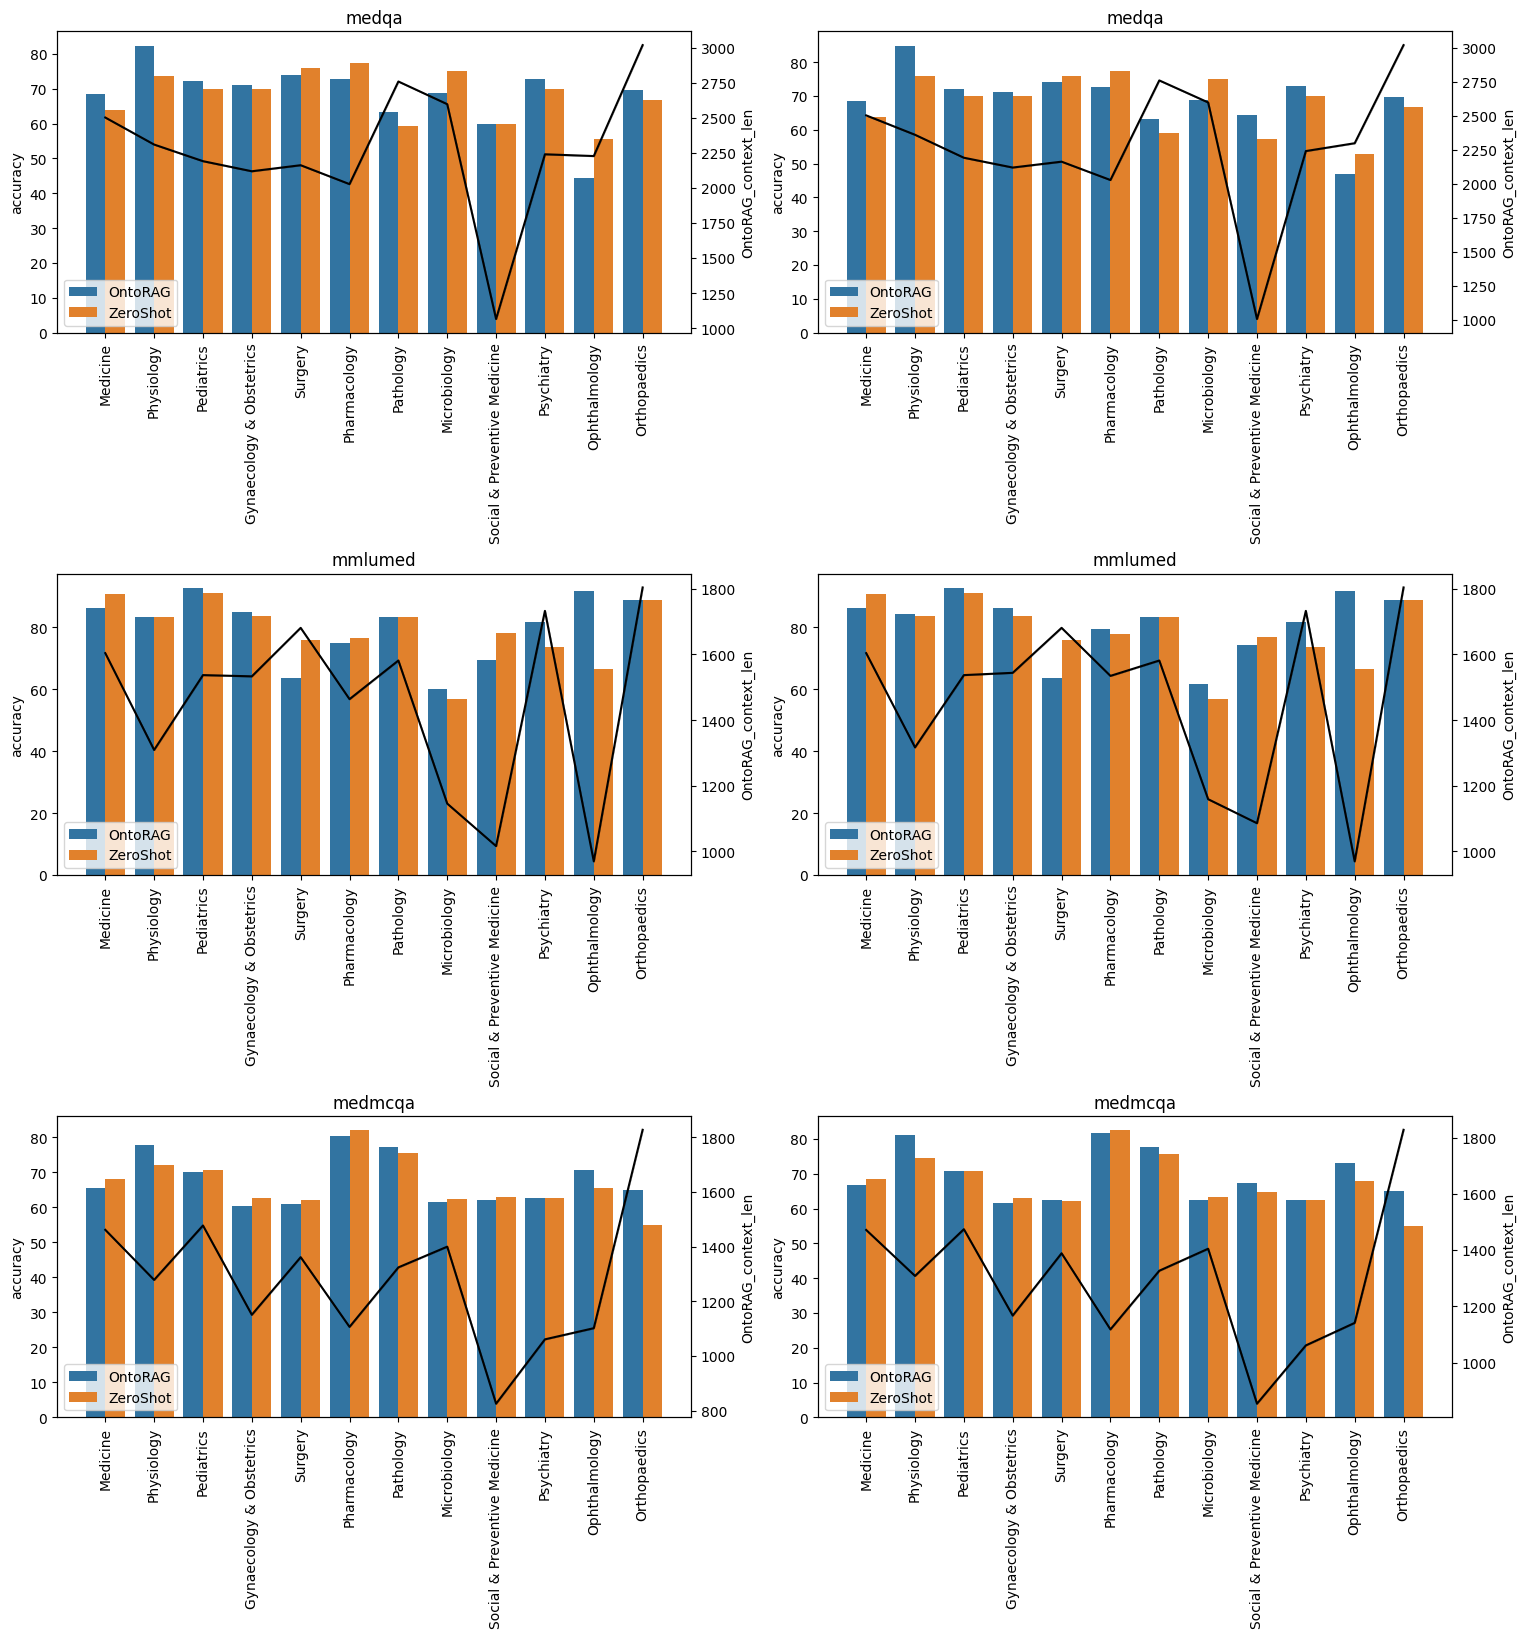

In [287]:
# Lets see per class

results_compare = {}
for bench in ["medqa", "mmlumed", "medmcqa"]:
    compare = []
    for name, dfm in zip(["OntoRAG", "ZeroShot"], [dfref_orag, dfref_zs]):
        if "class_1" not in dfm[bench]:
            dfm[bench]["class_1"] = dfm[bench]["class"]
        compare.append(
            dfm[bench]
            .groupby("class_1")
            .apply(
                lambda x: pd.Series(
                    {
                        name: np.mean(x["answer"] == x["choice_answer"]) * 100,
                        f"{name}_context_len": np.mean(
                            x["context"].astype(str).apply(len)
                        ),
                        "len": len(x["context"]),
                    },
                ),
                include_groups=False,
            )
        )

    compare = pd.concat(compare, axis=1).T.drop_duplicates().T
    comp_sorted = compare.sort_values("len", ascending=False)
    results_compare[bench] = comp_sorted
    # display(comp_sorted.loc[comp_sorted['len'] > 10].head())
    # print('---')

# import matplotlib.pyplot as plt
# import seaborn as sns

# fig, ax = plt.subplots(3, 1, figsize=(10, 18), gridspec_kw={'hspace': 0.8})

for i, bench in enumerate(["medqa", "mmlumed", "medmcqa"]):
    data = (
        results_compare[bench]
        .reset_index()
        .melt(
            value_vars=["OntoRAG", "ZeroShot"],
            id_vars=["class_1", "len", "OntoRAG_context_len"],
            var_name="variable",
            value_name="accuracy",
        )
    )
    data = data.set_index("class_1").loc[order]

    sns.barplot(
        data=data,
        x="class_1",
        y="accuracy",
        hue="variable",
        ax=ax[i, 1],
    )

    # overlay context_len as a new y axis lineplot
    ax2 = ax[i, 1].twinx()
    sns.lineplot(
        data=data,
        x="class_1",
        y="OntoRAG_context_len",
        ax=ax2,
        color="black",
        alpha=1,
    )
    ax[i, 1].set_title(bench)
    ax[i, 1].set_xlabel("")
    ax[i, 1].legend(loc="lower left")

    # rotate x labels
    for tick in ax[i, 1].get_xticklabels():
        tick.set_rotation(90)

plt.show()

In [293]:
# Recalculate accuracies for both refusal and normal
for k, df in dfref_orag.items():
    oragaft = np.mean(df["answer"] == df["choice_answer"]) * 100
    zsaft = (
        np.mean(dfref_zs[k]["answer"] == dfref_zs[k]["choice_answer"]) * 100
    )
    print(f"{k}: {oragaft:.4f}, {zsaft:.4f}")

    oragbef = (
        np.mean(dfm_orag[k]["answer"] == dfm_orag[k]["choice_answer"]) * 100
    )
    zsbef = np.mean(dfm_zs[k]["answer"] == dfm_zs[k]["choice_answer"]) * 100
    print(f"{k}: {oragbef:.4f}, {zsbef:.4f}")
    print("---")

medqa: 70.4724, 68.0315
medqa: 70.3064, 68.0283
---
mmlumed: 82.9810, 82.4932
mmlumed: 81.8279, 82.2020
---
medmcqa: 65.9211, 65.8708
medmcqa: 62.7062, 64.8099
---
